<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/qo20b88v1hbjztubt06609ovs85q8fau.png" width="400px" align="center"></a>

<h1 align="center"><font size="5">RESTRICTED BOLTZMANN MACHINES</font></h1>

<h3>Introduction</h3>
<b>Restricted Boltzmann Machine (RBM):</b>  RBMs are shallow neural nets that learn to reconstruct data by themselves in an unsupervised fashion.  


<h4>Why are RBMs important?</h4>
It can automatically extract <b>meaningful</b> features from a given input.


<h4>How does it work?</h4>
RBM is a 2 layer neural network. Simply, RBM takes the inputs and translates those into a set of binary values that represents them in the hidden layer. Then, these numbers can be translated back to reconstruct the inputs. Through several forward and backward passes, the RBM will be trained, and a trained RBM can reveal which features are the most important ones when detecting patterns.   


<h4>What are the applications of RBM?</h4>
RBM is useful for <a href='http://www.cs.utoronto.ca/~hinton/absps/netflixICML.pdf'>  Collaborative Filtering</a>, dimensionality reduction, classification, regression, feature learning, topic modeling and even <b>Deep Belief Networks</b>.



<h4>Is RBM a generative or Discriminative model?</h4>
RBM is a generative model. Let me explain it by first, see what is different between discriminative and generative models: 

<b>Discriminative:</b> Consider a classification problem in which we want to learn to distinguish between Sedan cars (y = 1) and SUV cars (y = 0), based on some features of cars. Given a training set, an algorithm like logistic regression tries to find a straight line—that is, a decision boundary—that separates the suv and sedan.  
<b>Generative:</b> looking at cars, we can build a model of what Sedan cars look like. Then, looking at SUVs, we can build a separate model of what SUV cars look like. Finally, to classify a new car, we can match the new car against the Sedan model, and match it against the SUV model, to see whether the new car looks more like the SUV or Sedan. 

Generative Models specify a probability distribution over a dataset of input vectors. We can do both supervise and unsupervised tasks with generative models:
<ul>
    <li>In an unsupervised task, we try to form a model for P(x), where P is the probability given x as an input vector.</li>
    <li>In the supervised task, we first form a model for P(x|y), where P is the probability of x given y(the label for x). For example, if y = 0 indicates whether a car is a SUV or y = 1 indicates indicate a car is a Sedan, then p(x|y = 0) models the distribution of SUVs’ features, and p(x|y = 1) models the distribution of Sedans’ features. If we manage to find P(x|y) and P(y), then we can use <code>Bayes rule</code> to estimate P(y|x), because: $$p(y|x) = \frac{p(x|y)p(y)}{p(x)}$$</li>
</ul>
Now the question is, can we build a generative model, and then use it to create synthetic data by directly sampling from the modeled probability distributions? Lets see. 

<h2>Table of Contents</h2>
<ol>
    <li><a href="#ref1">Initialization</a></li>
    <li><a href="#ref2">RBM layers</a></li>
    <li><a href="#ref3">What RBM can do after training?</a></li>
    <li><a href="#ref4">How to train the model?</a></li>
    <li><a href="#ref5">Learned features</a></li>
</ol>
<p></p>
</div>
<br>

<hr>

<a id="ref1"></a>
<h3>Initialization</h3>

First we have to load the utility file which contains different utility functions that are not connected
in any way to the networks presented in the tutorials, but rather help in
processing the outputs into a more understandable way.

In [1]:
import urllib.request
with urllib.request.urlopen("http://deeplearning.net/tutorial/code/utils.py") as url:
    response = url.read()
target = open('utils.py', 'w')
target.write(response.decode('utf-8'))
target.close()

Now, we load in all the packages that we use to create the net including the TensorFlow package:

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
#!pip install pillow
from PIL import Image
from utils import tile_raster_images
import matplotlib.pyplot as plt
%matplotlib inline

<hr>

<a id="ref2"></a>
<h3>RBM layers</h3>

An RBM has two layers. The first layer of the RBM is called the <b>visible</b> (or input layer). Imagine that our toy example, has only vectors with 7 values, so the visible layer must have j=7 input nodes. 
The second layer is the <b>hidden</b> layer, which possesses i neurons in our case. Each hidden node can have either 0 or 1 values (i.e., si = 1 or si = 0) with a probability that is a logistic function of the inputs it receives from the other j visible units, called for example, p(si = 1). For our toy sample, we'll use 2 nodes in the hidden layer, so i = 2.

<center><img src="https://ibm.box.com/shared/static/eu26opvcefgls6vnwuo29uwp0nudmokh.png" alt="RBM Model" style="width: 400px;"></center>

     

Each node in the first layer also has a <b>bias</b>. We will denote the bias as “v_bias” for the visible units. The <b>v_bias</b> is shared among all visible units.

Here we define the <b>bias</b> of second layer as well. We will denote the bias as “h_bias” for the hidden units. The <b>h_bias</b> is shared among all hidden units

In [3]:
v_bias = tf.placeholder("float", [7])
h_bias = tf.placeholder("float", [2])

We have to define weights among the input layer and hidden layer nodes. In the weight matrix, the number of rows are equal to the input nodes, and the number of columns are equal to the output nodes. Let <b>W</b> be the Tensor of 7x2 (7 - number of visible neurons, 2 - number of hidden neurons) that represents weights between neurons. 

In [4]:
W = tf.constant(np.random.normal(loc=0.0, scale=1.0, size=(7, 2)).astype(np.float32))

<hr>

<a id="ref3"></a>
<h3>What RBM can do after training?</h3>
Think RBM as a model that has been trained based on images of a dataset of many SUV and Sedan cars. Also, imagine that the RBM network has only two hidden nodes, one for the weight and, and one for the size of cars, which in a sense, their different configurations represent different cars, one represent SUV cars and one for Sedan. In a training process, through many forward and backward passes, RBM adjust its weights to send a stronger signal to either the SUV node (0, 1) or the Sedan node (1, 0) in the hidden layer, given the pixels of images. Now, given a SUV in hidden layer, which distribution of pixels should we expect? RBM can give you 2 things. First, it encodes your images in hidden layer. Second, it gives you the probability of observing a case, given some hidden values.


<h3>How to inference?</h3>

RBM has two phases:
<ul>
    <li>Forward Pass</li>  
    <li>Backward Pass or Reconstruction</li>
</ul>

<b>Phase 1) Forward pass:</b>  Input one training sample (one image) <b>X</b> through all visible nodes, and pass it to all hidden nodes. Processing happens in each node in the hidden layer. This computation begins by making stochastic decisions about whether to transmit that input or not (i.e. to determine the state of each hidden layer). At the hidden layer's nodes, <b>X</b> is multiplied by a <b>$W_{ij}$</b> and added to <b>h_bias</b>. The result of those two operations is fed into the sigmoid function, which produces the node’s output, $p({h_j})$, where j is the unit number. 


$p({h_j})= \sigma(\sum_i w_{ij} x_i)$, where $\sigma()$ is the logistic function.


Now lets see what $p({h_j})$ represents. In fact, it is the probabilities of the hidden units. And, all values together are called <b>probability distribution</b>. That is, RBM uses inputs x to make predictions about hidden node activations. For example, imagine that the values of $h_p$ for the first training item is [0.51 0.84]. It tells you what is the conditional probability for each hidden neuron to be at Phase 1): 
<ul>
    <li>p($h_{1}$ = 1|V) = 0.51</li>
    <li>($h_{2}$ = 1|V) = 0.84</li>  
</ul>

As a result, for each row in the training set, <b>a vector/tensor</b> is generated, which in our case it is of size [1x2], and totally n vectors ($p({h})$=[nx2]). 

We then turn unit $h_j$ on with probability $p(h_{j}|V)$, and turn it off with probability $1 - p(h_{j}|V)$.

Therefore, the conditional probability of a configuration of h given v (for a training sample) is:

$$p(\mathbf{h} \mid \mathbf{v}) = \prod_{j=0}^H p(h_j \mid \mathbf{v})$$

Now, sample a hidden activation vector <b>h</b> from this probability distribution $p({h_j})$. That is, we sample the activation vector from the probability distribution of hidden layer values. 

Before we go further, let's look at a toy example for one case out of all input. Assume that we have a trained RBM, and a very simple input vector such as [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], lets see what would be the output of forward pass:

In [5]:
sess = tf.Session()
X = tf.constant([[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]])
v_state = X
print ("Input: ", sess.run(v_state))

h_bias = tf.constant([0.1, 0.1])
print ("hb: ", sess.run(h_bias))
print ("w: ", sess.run(W))

# Calculate the probabilities of turning the hidden units on:
h_prob = tf.nn.sigmoid(tf.matmul(v_state, W) + h_bias)  #probabilities of the hidden units
print ("p(h|v): ", sess.run(h_prob))

# Draw samples from the distribution:
h_state = tf.nn.relu(tf.sign(h_prob - tf.random_uniform(tf.shape(h_prob)))) #states
print ("h0 states:", sess.run(h_state))

Input:  [[1. 0. 0. 1. 0. 0. 0.]]
hb:  [0.1 0.1]
w:  [[-0.17890443  0.65993816]
 [-0.00903554  0.24074677]
 [-1.0502143  -0.37581968]
 [-2.846199    0.36473757]
 [ 0.03976738  2.1868887 ]
 [ 0.78772306  1.5118037 ]
 [ 0.69014883  0.6616242 ]]
p(h|v):  [[0.05092646 0.754855  ]]
h0 states: [[0. 0.]]


<b>Phase 2) Backward Pass (Reconstruction):</b>
The RBM reconstructs data by making several forward and backward passes between the visible and hidden layers.

So, in the second phase (i.e. reconstruction phase), the samples from the hidden layer (i.e. h) play the role of input. That is, <b>h</b> becomes the input in the backward pass. The same weight matrix and visible layer biases are used to go through the sigmoid function. The produced output is a reconstruction which is an approximation of the original input.

In [6]:
vb = tf.constant([0.1, 0.2, 0.1, 0.1, 0.1, 0.2, 0.1])
print ("b: ", sess.run(vb))
v_prob = sess.run(tf.nn.sigmoid(tf.matmul(h_state, tf.transpose(W)) + vb))
print ("p(vi∣h): ", v_prob)
v_state = tf.nn.relu(tf.sign(v_prob - tf.random_uniform(tf.shape(v_prob))))
print ("v probability states: ", sess.run(v_state))

b:  [0.1 0.2 0.1 0.1 0.1 0.2 0.1]
p(vi∣h):  [[0.6813403  0.60843694 0.43147892 0.6141375  0.9077853  0.8470701
  0.68170625]]
v probability states:  [[0. 1. 1. 1. 1. 0. 1.]]


RBM learns a probability distribution over the input, and then, after being trained, the RBM can generate new samples from the learned probability distribution. As you know, <b>probability distribution</b>, is a mathematical function that provides the probabilities of occurrence of different possible outcomes in an experiment.

The (conditional) probability distribution over the visible units v is given by

$p(\mathbf{v} \mid \mathbf{h}) = \prod_{i=0}^V p(v_i \mid \mathbf{h}),$


where,

$p(v_i \mid \mathbf{h}) = \sigma\left( a_i + \sum_{j=0}^H w_{ji} h_j \right)$

so, given current state of hidden units and weights, what is the probability of generating [1. 0. 0. 1. 0. 0. 0.] in reconstruction phase, based on the above <b>probability distribution</b> function?

In [7]:
inp = sess.run(X)
print(inp)
print(v_prob[0])
v_probability = 1
for elm, p in zip(inp[0],v_prob[0]) :
    if elm ==1:
        v_probability *= p
    else:
        v_probability *= (1-p)
v_probability

[[1. 0. 0. 1. 0. 0. 0.]]
[0.6813403  0.60843694 0.43147892 0.6141375  0.9077853  0.8470701
 0.68170625]


0.0004181177847953282

How similar X and V vectors are? Of course, the reconstructed values most likely will not look anything like the input vector because our network has not trained yet. Our objective is to train the model in such a way that the input vector and reconstructed vector to be same. Therefore, based on how different the input values look to the ones that we just reconstructed, the weights are adjusted. 

<hr>


<h2>MNIST</h2>


We will be using the MNIST dataset to practice the usage of RBMs. The following cell loads the MNIST dataset.

In [8]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Lets look at the dimension of the images.

In [9]:
trX[1].shape

(784,)

MNIST images have 784 pixels, so the visible layer must have 784 input nodes.  For our case, we'll use 50 nodes in the hidden layer, so i = 50.

In [14]:
vb = tf.placeholder("float", [784])
hb = tf.placeholder("float", [50])

Let <b>W</b> be the Tensor of 784x50 (784 - number of visible neurons, 50 - number of hidden neurons) that represents weights between the neurons. 

In [15]:
W = tf.placeholder("float", [784, 50])

Lets define the visible layer:

In [16]:
v0_state = tf.placeholder("float", [None, 784])

Now, we can define hidden layer:

In [17]:
h0_prob = tf.nn.sigmoid(tf.matmul(v0_state, W) + hb)  #probabilities of the hidden units
h0_state = tf.nn.relu(tf.sign(h0_prob - tf.random_uniform(tf.shape(h0_prob)))) #sample_h_given_X

Now, we define reconstruction part:

In [18]:
v1_prob = tf.nn.sigmoid(tf.matmul(h0_state, tf.transpose(W)) + vb) 
v1_state = tf.nn.relu(tf.sign(v1_prob - tf.random_uniform(tf.shape(v1_prob)))) #sample_v_given_h

<h3>What is objective function?</h3>

<b>Goal</b>: Maximize the likelihood of our data being drawn from that distribution

<b>Calculate error:</b>  
In each epoch, we compute the "error" as a sum of the squared difference between step 1 and step n,
e.g the error shows the difference between the data and its reconstruction.

<b>Note:</b> tf.reduce_mean computes the mean of elements across dimensions of a tensor.

In [19]:
err = tf.reduce_mean(tf.square(v0_state - v1_state))

<a id="ref4"></a>
<h3>How to train the model?</h3>
<b>Warning!!</b> The following part discuss how to train the model which needs some algebra background. Still, you can skip this part and run the next cells.

As mentioned, we want to give a high probability to the input data we train on. So, in order to train an RBM, we have to maximize the product of probabilities assigned to all rows v (images) in the training set V (a matrix, where each row of it is treated as a visible vector v):

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/d42e9f5aad5e1a62b11b119c9315236383c1864a">


Which is equivalent, maximizing the expected log probability of V:


<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/ba0ceed99dca5ff1d21e5ace23f5f2223f19efc0">


So, we have to update the weights wij  to increase p(v) for all v in our training data during training. So we have to calculate the derivative:


$$\frac{\partial \log p(\mathbf v)}{\partial w_{ij}}$$

This cannot be easily done by typical <b>gradient descent (SGD)</b>, so we can use another approach, which has 2 steps:
<ol>
    <li>Gibbs Sampling</li>
    <li>Contrastive Divergence</li>
</ol>    
    
<h3>Gibbs Sampling</h3>   
First, given an input vector v we are using p(h|v) for prediction of the hidden values h. 
<ul>
    <li>$p(h|v) = sigmoid(X \otimes W + hb)$</li>
    <li>h0 = sampleProb(h0)</li>
</ul>
    
Then, knowing the hidden values, we use p(v|h) for reconstructing of new input values v. 
<ul>
    <li>$p(v|h) = sigmoid(h0 \otimes transpose(W) + vb)$</li>
    <li>$v1 = sampleProb(v1)$  (Sample v given h)</li>
</ul>
        
This process is repeated k times. After k iterations we obtain an other input vector vk which was recreated from original input values v0 or X.

Reconstruction steps:
<ul>
    <li> Get one data point from data set, like <i>x</i>, and pass it through the net</li>
    <li>Pass 0: (x)  $\Rightarrow$ (h0) $\Rightarrow$  (v1)   (v1 is reconstruction of the first pass)</li>
    <li>Pass 1: (v1) $\Rightarrow$  (h1) $\Rightarrow$  (v2)   (v2 is reconstruction of the second pass)</li>
    <li>Pass 2: (v2) $\Rightarrow$  (h2) $\Rightarrow$  (v3)   (v3 is reconstruction of the third pass)</li>
    <li>Pass n: (vk) $\Rightarrow$  (hk+1) $\Rightarrow$  (vk+1)(vk is reconstruction of the nth pass)</li>
</ul>
        
<h4>What is sampling here (sampleProb)?</h4>

In forward pass: We randomly set the values of each hi to be 1 with probability $sigmoid(v \otimes W + hb)$.  
- To sample h given v means to sample from the conditional probability distribution P(h|v). It means that you are asking what are the probabilities of getting a specific set of values for the hidden neurons, given the values v for the visible neurons, and sampling from this probability distribution. 
In reconstruction: We randomly set the values of each vi to be 1 with probability $ sigmoid(h \otimes transpose(W) + vb)$.

<h3>contrastive divergence (CD-k)</h3>
The update of the weight matrix is done during the Contrastive Divergence step. 

Vectors v0 and vk are used to calculate the activation probabilities for hidden values h0 and hk. The difference between the outer products of those probabilities with input vectors v0 and vk results in the update matrix:


$\Delta W =v0 \otimes h0 - vk \otimes hk$ 

Contrastive Divergence is actually matrix of values that is computed and used to adjust values of the W matrix. Changing W incrementally leads to training of W values. Then on each step (epoch), W is updated to a new value W' through the equation below:

$W' = W + alpha * \Delta W$ 

 
<b>What is Alpha?</b>  
Here, alpha is some small step rate and is also known as the "learning rate".




Ok, lets assume that k=1, that is we just get one more step:

In [20]:
h1_prob = tf.nn.sigmoid(tf.matmul(v1_state, W) + hb)
h1_state = tf.nn.relu(tf.sign(h1_prob - tf.random_uniform(tf.shape(h1_prob)))) #sample_h_given_X

In [21]:
alpha = 0.01
W_Delta = tf.matmul(tf.transpose(v0_state), h0_prob) - tf.matmul(tf.transpose(v1_state), h1_prob)
update_w = W + alpha * W_Delta
update_vb = vb + alpha * tf.reduce_mean(v0_state - v1_state, 0)
update_hb = hb + alpha * tf.reduce_mean(h0_state - h1_state, 0)

Let's start a session and initialize the variables:

In [22]:
cur_w = np.zeros([784, 50], np.float32)
cur_vb = np.zeros([784], np.float32)
cur_hb = np.zeros([50], np.float32)
prv_w = np.zeros([784, 50], np.float32)
prv_vb = np.zeros([784], np.float32)
prv_hb = np.zeros([50], np.float32)
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

Lets look at the error of the first run:

In [23]:
sess.run(err, feed_dict={v0_state: trX, W: prv_w, vb: prv_vb, hb: prv_hb})

0.48144573

Epoch: 0 reconstruction error: 0.088057
Epoch: 1 reconstruction error: 0.083573
Epoch: 2 reconstruction error: 0.082561
Epoch: 3 reconstruction error: 0.082458
Epoch: 4 reconstruction error: 0.082508


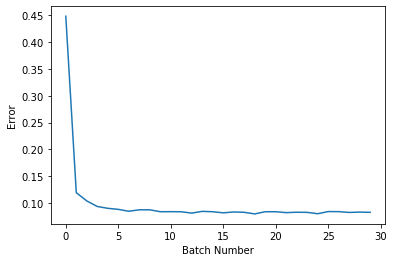

In [24]:
#Parameters
epochs = 5
batchsize = 100
weights = []
errors = []

for epoch in range(epochs):
    for start, end in zip( range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={ v0_state: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0_state: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict={ v0_state: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
        if start % 10000 == 0:
            errors.append(sess.run(err, feed_dict={v0_state: trX, W: cur_w, vb: cur_vb, hb: cur_hb}))
            weights.append(cur_w)
    print ('Epoch: %d' % epoch,'reconstruction error: %f' % errors[-1])
plt.plot(errors)
plt.xlabel("Batch Number")
plt.ylabel("Error")
plt.show()

What is the final weight after training?

In [25]:
uw = weights[-1].T
print (uw) # a weight matrix of shape (50,784)

[[-0.66135937 -0.6533911  -0.78827244 ... -0.7278663  -0.64976156
  -0.7141653 ]
 [-0.9281402  -0.9061437  -0.8697974  ... -0.9292593  -0.8651521
  -0.8164509 ]
 [-1.3657668  -1.4759426  -1.439846   ... -1.4520885  -1.3482738
  -1.3341781 ]
 ...
 [-0.79438055 -0.7177283  -0.6927285  ... -0.7517966  -0.7996873
  -0.61651504]
 [-0.629944   -0.56595105 -0.5664083  ... -0.5748426  -0.58775795
  -0.6209563 ]
 [-2.243206   -2.19833    -2.1845841  ... -2.2144704  -2.1318157
  -2.1510882 ]]


<a id="ref5"></a>
<h3>Learned features</h3> 

We can take each hidden unit and visualize the connections between that hidden unit and each element in the input vector. In our case, we have 50 hidden units. Lets visualize those.

Let's plot the current weights:
<b>tile_raster_images</b> helps in generating an easy to grasp image from a set of samples or weights. It transform the <b>uw</b> (with one flattened image per row of size 784), into an array (of size $25\times20$) in which images are reshaped and laid out like tiles on a floor.

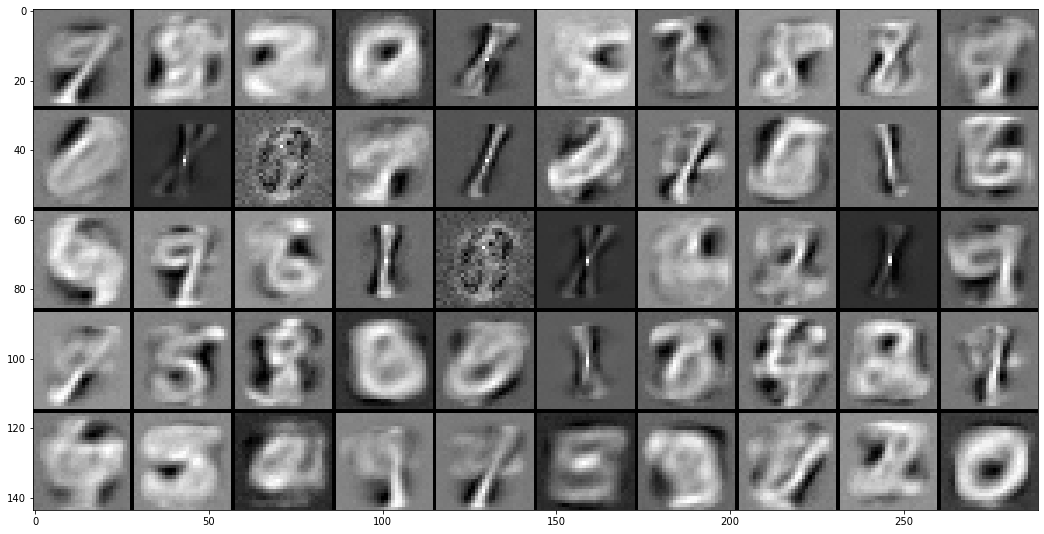

In [26]:
tile_raster_images(X=cur_w.T, img_shape=(28, 28), tile_shape=(5, 10), tile_spacing=(1, 1))
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
image = Image.fromarray(tile_raster_images(X=cur_w.T, img_shape=(28, 28) ,tile_shape=(5, 10), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

Each tile in the above visualization corresponds to a vector of connections between a hidden unit and visible layer's units. 

Let's look at one of the learned weights corresponding to one of hidden units for example. In this particular square, the gray color represents weight = 0, and the whiter it is, the more positive the weights are (closer to 1). Conversely, the darker pixels are, the more negative the weights. The positive pixels will increase the probability of activation in hidden units (after multiplying by input/visible pixels), and negative pixels will decrease the probability of a unit hidden to be 1 (activated). So, why is this important?  So we can see that this specific square (hidden unit) can detect a feature (e.g. a "/" shape) and if it exists in the input.

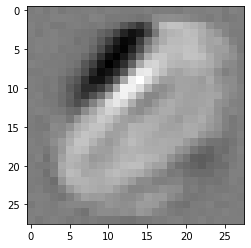

In [27]:
from PIL import Image
image = Image.fromarray(tile_raster_images(X =cur_w.T[10:11], img_shape=(28, 28),tile_shape=(1, 1), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (4.0, 4.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

Let's look at the reconstruction of an image now. Imagine that we have a destructed image of figure 3. Lets see if our trained network can fix it:

First we plot the image:

--2020-02-29 02:38:31--  https://ibm.box.com/shared/static/vvm1b63uvuxq88vbw9znpwu5ol380mco.jpg
Resolving ibm.box.com (ibm.box.com)... 107.152.27.197, 107.152.26.197
Connecting to ibm.box.com (ibm.box.com)|107.152.27.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/vvm1b63uvuxq88vbw9znpwu5ol380mco.jpg [following]
--2020-02-29 02:38:32--  https://ibm.box.com/public/static/vvm1b63uvuxq88vbw9znpwu5ol380mco.jpg
Reusing existing connection to ibm.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.ent.box.com/public/static/vvm1b63uvuxq88vbw9znpwu5ol380mco.jpg [following]
--2020-02-29 02:38:32--  https://ibm.ent.box.com/public/static/vvm1b63uvuxq88vbw9znpwu5ol380mco.jpg
Resolving ibm.ent.box.com (ibm.ent.box.com)... 107.152.27.211, 107.152.26.211
Connecting to ibm.ent.box.com (ibm.ent.box.com)|107.152.27.211|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: h

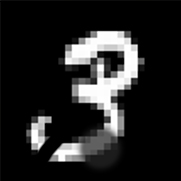

In [28]:
!wget -O destructed3.jpg  https://ibm.box.com/shared/static/vvm1b63uvuxq88vbw9znpwu5ol380mco.jpg
img = Image.open('destructed3.jpg')
img

Now let's pass this image through the net:

In [29]:
# convert the image to a 1d numpy array
sample_case = np.array(img.convert('I').resize((28,28))).ravel().reshape((1, -1))/255.0

Feed the sample case into the network and reconstruct the output:

In [30]:
hh0_p = tf.nn.sigmoid(tf.matmul(v0_state, W) + hb)
#hh0_s = tf.nn.relu(tf.sign(hh0_p - tf.random_uniform(tf.shape(hh0_p)))) 
hh0_s = tf.round(hh0_p)
hh0_p_val,hh0_s_val  = sess.run((hh0_p, hh0_s), feed_dict={ v0_state: sample_case, W: prv_w, hb: prv_hb})
print("Probability nodes in hidden layer:" ,hh0_p_val)
print("activated nodes in hidden layer:" ,hh0_s_val)

# reconstruct
vv1_p = tf.nn.sigmoid(tf.matmul(hh0_s_val, tf.transpose(W)) + vb)
rec_prob = sess.run(vv1_p, feed_dict={ hh0_s: hh0_s_val, W: prv_w, vb: prv_vb})

Probability nodes in hidden layer: [[2.4414349e-22 5.1566088e-03 1.0000000e+00 6.6016535e-03 1.7734272e-23
  7.0148307e-19 3.8478073e-23 9.7420132e-14 2.3686282e-14 9.4971583e-06
  1.2954398e-11 3.5236679e-15 5.9698698e-13 3.1288069e-11 1.0027746e-20
  5.1895754e-23 1.1866134e-17 9.9986529e-01 4.4696192e-22 5.4592625e-33
  1.2021630e-33 1.4456637e-11 6.1701557e-32 3.6093517e-21 1.1293317e-11
  8.6243217e-16 4.0546636e-23 1.5240795e-11 5.5871389e-21 4.8130968e-26
  2.1108708e-23 3.0355114e-08 9.2817158e-05 1.3018459e-10 9.9762732e-01
  2.9991170e-19 2.5879962e-07 4.0965571e-26 9.4075892e-10 1.0678808e-18
  1.7838469e-25 7.8449970e-01 6.8179297e-01 1.8941604e-21 1.0372334e-21
  1.0000000e+00 2.2436500e-14 1.6722986e-02 6.9612183e-04 4.7122428e-10]]
activated nodes in hidden layer: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0.
  0. 0.]]


Here we plot the reconstructed image:

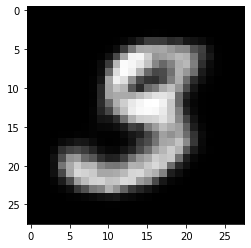

In [31]:
img = Image.fromarray(tile_raster_images(X=rec_prob, img_shape=(28, 28),tile_shape=(1, 1), tile_spacing=(1, 1)))
plt.rcParams['figure.figsize'] = (4.0, 4.0)
imgplot = plt.imshow(img)
imgplot.set_cmap('gray') 

<hr>

## Want to learn more?

Running deep learning programs usually needs a high performance platform. __PowerAI__ speeds up deep learning and AI. Built on IBM’s Power Systems, __PowerAI__ is a scalable software platform that accelerates deep learning and AI with blazing performance for individual users or enterprises. The __PowerAI__ platform supports popular machine learning libraries and dependencies including TensorFlow, Caffe, Torch, and Theano. You can use [PowerAI on IMB Cloud](https://cocl.us/ML0120EN_PAI).

Also, you can use __Watson Studio__ to run these notebooks faster with bigger datasets.__Watson Studio__ is IBM’s leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, __Watson Studio__ enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of __Watson Studio__ users today with a free account at [Watson Studio](https://cocl.us/ML0120EN_DSX).This is the end of this lesson. Thank you for reading this notebook, and good luck on your studies.

### Thanks for completing this lesson!

Notebook created by: <a href = "https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>

### References:
https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine  
http://deeplearning.net/tutorial/rbm.html  
http://www.cs.utoronto.ca/~hinton/absps/netflixICML.pdf<br>
http://imonad.com/rbm/restricted-boltzmann-machine/  


<hr>

Copyright &copy; 2018 [Cognitive Class](https://cocl.us/DX0108EN_CC). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).